In [1]:
import pandas as pd
import numpy as np
import json
import csv
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv("bbc-text.csv")

In [3]:
print(df)

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...
...,...,...
2220,business,cars pull down us retail figures us retail sal...
2221,politics,kilroy unveils immigration policy ex-chatshow ...
2222,entertainment,rem announce new glasgow concert us band rem h...
2223,politics,how political squabbles snowball it s become c...


In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [5]:

print(df.head(),"\n")
print(df.info())

        category                                               text
0           tech  tv future in the hands of viewers with home th...
1       business  worldcom boss  left books alone  former worldc...
2          sport  tigers wary of farrell  gamble  leicester say ...
3          sport  yeading face newcastle in fa cup premiership s...
4  entertainment  ocean s twelve raids box office ocean s twelve... 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB
None


In [6]:
category = pd.get_dummies(df.category)
df_baru = pd.concat([df, category], axis=1)
df_baru = df_baru.drop(columns='category')
print(df_baru)

,text,business,entertainment,politics,sport,tech
0,tv future in the hands of viewers with home th...,0,0,0,0,1
1,worldcom boss left books alone former worldc...,1,0,0,0,0
2,tigers wary of farrell gamble leicester say ...,0,0,0,1,0
3,yeading face newcastle in fa cup premiership s...,0,0,0,1,0
4,ocean s twelve raids box office ocean s twelve...,0,1,0,0,0
...,...,...,...,...,...,...
2220,cars pull down us retail figures us retail sal...,1,0,0,0,0
2221,kilroy unveils immigration policy ex-chatshow ...,0,0,1,0,0
2222,rem announce new glasgow concert us band rem h...,0,1,0,0,0
2223,how political squabbles snowball it s become c...,0,0,1,0,0


In [7]:
article = df_baru['text'].values
label = df_baru[['business', 'entertainment', 'politics','sport','tech']].values
label = np.argmax(label, axis=1)

In [8]:
from sklearn.model_selection import train_test_split
article_train, article_test, label_train, label_test = train_test_split(article, label, test_size=0.2)

In [9]:
print(article.shape)

(2225,)

In [10]:
print(label_train.shape)

(1780,)

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
 
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(article_train) 
tokenizer.fit_on_texts(article_train)
 
sekuens_latih = tokenizer.texts_to_sequences(article_train)
sekuens_test = tokenizer.texts_to_sequences(article_test)
 
padded_latih = pad_sequences(sekuens_latih, maxlen=200, padding='post', truncating='post') 
padded_test = pad_sequences(sekuens_test, maxlen=200, padding='post', truncating='post') 

In [12]:
print(padded_test.shape)

(445, 200)

In [14]:
label

array([4, 0, 3, ..., 1, 2, 3], dtype=int64)

In [22]:
import tensorflow as tf
from tensorflow.keras.backend import clear_session
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, LSTM, Flatten, Bidirectional
from tensorflow.keras.layers import Dropout, Embedding,GlobalMaxPool1D,SpatialDropout1D
from tensorflow.keras.models import Sequential
print(tf.__version__)
L2 = 0.0000001
embedding_dim=256
n_class = 5

clear_session()
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=embedding_dim))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(embedding_dim,kernel_initializer='orthogonal', kernel_regularizer=l2(L2), recurrent_regularizer=l2(L2),
         bias_regularizer=l2(L2))))
model.add(Dense(embedding_dim, activation='relu',kernel_regularizer=l2(L2), bias_regularizer=l2(L2)))
model.add(Dense(n_class, activation='softmax',kernel_regularizer=l2(L2), bias_regularizer=l2(L2) ))
model.summary()

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy')>0.97):
            print("\nAkurasi telah mencapai > 97%!")
            self.model.stop_training = True

callbacks = myCallback()

model.compile(loss='sparse_categorical_crossentropy',optimizer='nadam',metrics=['accuracy'])

num_epochs = 20
lstm = model.fit(padded_latih, label_train, epochs=num_epochs, 
                    validation_data=(padded_test, label_test),callbacks=[callbacks],verbose=2)

2.1.0
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 256)         1280000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, None, 256)         0         
_________________________________________________________________
bidirectional (Bidirectional (None, 512)               1050624   
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1285      
Total params: 2,463,237
Trainable params: 2,463,237
Non-trainable params: 0
_________________________________________________________________
Train on 1780 samples, validate on 445 samples
Epoch 1/20
1780/1780 - 5s - loss: 1.6646 - accuracy: 0.3770

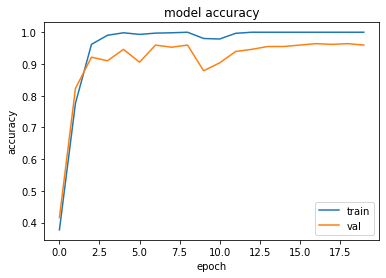

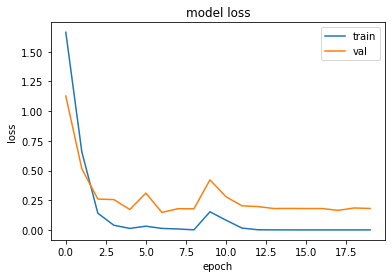

In [23]:
plt.plot(lstm.history['accuracy'])
plt.plot(lstm.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

plt.plot(lstm.history['loss'])
plt.plot(lstm.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()